# CSE 519 Homework-3: Google Analytics Customer Revenue Prediction

### Imports

In [15]:
import numpy as np 
import pandas as pd
# Import matplotlib & seaborn for visualisation
import json
from pandas.io.json import json_normalize
import seaborn as sns 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st

## 1. Data Cleaning 

The training and test data contains Nested JSON columns which we need to flatten.
There are 4 JSON columns which can be flattened. 
I have referred the kernel by Jullian Peller for flattening the JSON fields.
The link for the same is: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

#### Function for flattening the JSON fields
There are 4 columns: 'device', 'geoNetwork, 'totals', 'trafficSource' that are flattened
Note: fullVisitorId is mentioned as string because the output file is expected in that format.

In [ ]:
# def load_df(csv_path='gdrive/My Drive/Colab Notebooks/Datasets/Google Analytics/train.csv', nrows=None):
#     JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
#     df = pd.read_csv(csv_path, 
#                      converters={column: json.loads for column in JSON_COLUMNS}, 
#                      dtype={'fullVisitorId': 'str'}, # Important!!
#                      nrows=nrows)
    
#     for column in JSON_COLUMNS:
#         column_as_df = json_normalize(df[column])
#         column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
#         df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#     print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
#     return df

Call the function on Training and Test Dataframes

In [ ]:
# %%time
# train_df = load_df()
# test_df = load_df("gdrive/My Drive/Colab Notebooks/Datasets/Google Analytics/test.csv")

I saved these to a new CSV file for easier access later

In [ ]:
# %%time
# df_train.to_csv("gdrive/My Drive/Colab Notebooks/Datasets/Google Analytics/train-flattened.csv", index=False)
# df_test.to_csv("gdrive/My Drive/Colab Notebooks/Datasets/Google Analytics/test-flattened.csv", index=False)


Load the training dataset[flattened]

In [45]:
train_df = pd.read_csv('./Dataset/train-flattened.csv',
                      dtype={'fullVisitorId':'str',
                            'trafficSource.campaignCode':'str'})
train_df.head(3)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


Similarly, load the test dataset into a dataframe

In [46]:
test_df = pd.read_csv("./Dataset/test-flattened.csv",
                     dtype={'fullVisitorId':'str',
                            'trafficSource.campaignCode':str}
                     )

In [5]:
test_df.head(3)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


In [6]:
print(train_df.info(),test_df.info())
## This is to check how many null values could be present in the dataset, both training and testing dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

In [18]:
print(train_df.shape,test_df.shape)

(903653, 55) (804684, 53)


Now we mainly have two types of features ->
Categorical Features and Numerical features. 

Let us check how many values are NaN or missing from the dataset.

Training Dataset Numerical Features

In [47]:
numeric_features_train = train_df.select_dtypes(include=[np.number])

numeric_features_train.columns

Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'totals.visits',
       'trafficSource.adwordsClickInfo.page'],
      dtype='object')

Test Dataset Numerical Features

In [48]:
numeric_features_test = test_df.select_dtypes(include=[np.number])
numeric_features_test.columns

Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.adwordsClickInfo.page'],
      dtype='object')

In [10]:
print(len(numeric_features_train.columns),len(numeric_features_test.columns) )

11 10


Training Data Categorical Features

In [49]:
categorical_features_train = train_df.select_dtypes(include=[np.object])
categorical_features_train.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.language',
       'device.mobileDeviceBranding', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.operatingSystem',
       'device.operatingSystemVersion', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.city', 'geoNetwork.cityId',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.metro', 'geoNetwork.networkDomain',
       'geoNetwork.networkLocation', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.adwordsClickInfo.gclId',
  

In [51]:
categorical_features_test = test_df.select_dtypes(include=[np.object])
categorical_features_test.columns

#### Let us remove the columns that are not required

In [52]:
print ("Before removing constant columns - shape of train & test datasets: ", train_df.shape,test_df.shape)

train_df = train_df.loc[:, (train_df != train_df.iloc[0]).any()]

test_df = test_df.loc[:, (test_df != test_df.iloc[0]).any()]

print ("After Removing Constant Columns - shape of train & test datasets: ", train_df.shape,test_df.shape)

Before removing constant columns - shape of train & test datasets:  (903653, 55) (804684, 53)
After Removing Constant Columns - shape of train & test datasets:  (903653, 36) (804684, 34)


Now, to further clean the data, we need to remove columns that have null values.
To check this, we first check how many categorical features have null values and then check the numeric features having null values.

Check what percent of the categorical training features have null values.

In [53]:
total_test = categorical_features_train.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_train.isnull().sum()/categorical_features_train.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Null Values'])
missing_data.index.name ='Feature'
missing_data.head(10)

,Total Missing Count,% of Null Values
Feature,,
trafficSource.campaignCode,903652,99.999889
trafficSource.adContent,892707,98.788694
trafficSource.adwordsClickInfo.isVideoAd,882193,97.625195
trafficSource.adwordsClickInfo.adNetworkType,882193,97.625195
trafficSource.adwordsClickInfo.slot,882193,97.625195
trafficSource.adwordsClickInfo.gclId,882092,97.614018
trafficSource.isTrueDirect,629648,69.678073
trafficSource.referralPath,572712,63.377425
trafficSource.keyword,502929,55.655102


As we can see, trafficSource.campaignCode, trafficSource.adContent and so on(almost 10 columns) have a majority of NULL values. So this should be factored while cleaning the dataset.

After this, let's do the same for the test dataset.

In [54]:
total_test = categorical_features_test.isnull().sum().sort_values(ascending=False)
percent = (categorical_features_test.isnull().sum()/categorical_features_test.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total_test, percent], axis=1,join='outer', keys=['Total Missing Count', ' % of Null values'])
missing_data.index.name ='Feature'
missing_data.head(10)

,Total Missing Count,% of Null values
Feature,,
trafficSource.adContent,750893,93.315264
trafficSource.adwordsClickInfo.slot,750870,93.312406
trafficSource.adwordsClickInfo.isVideoAd,750870,93.312406
trafficSource.adwordsClickInfo.adNetworkType,750870,93.312406
trafficSource.adwordsClickInfo.gclId,750822,93.306441
trafficSource.referralPath,569361,70.755850
trafficSource.isTrueDirect,544171,67.625428
trafficSource.keyword,391032,48.594479
trafficSource.source,0,0.000000


## 2. Heatmap and other interesting plots

I took a subset of the numerical values and tried to plot a heatmap

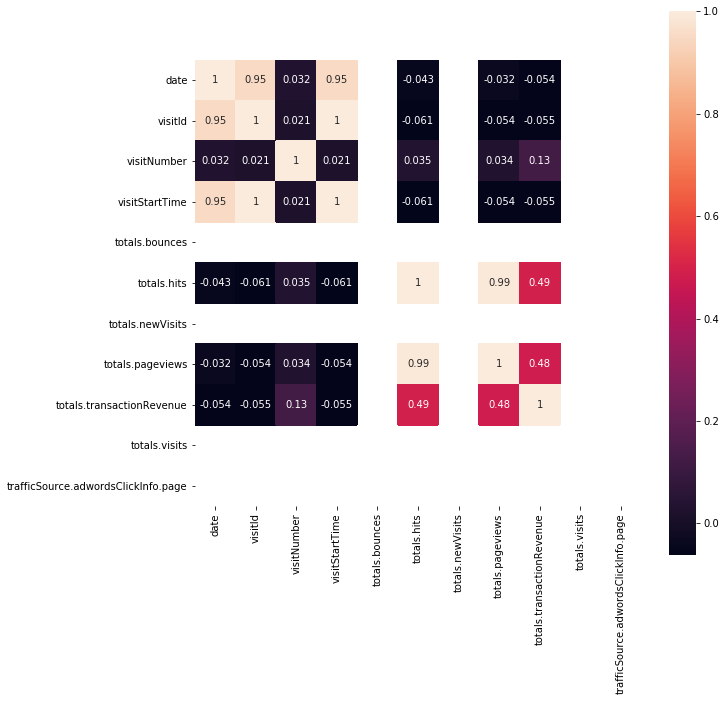

In [63]:
corr = numeric_features_train[0:5000].astype(np.number).corr()
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(corr, square=True, annot=True)

In [64]:
# Visualization for Visits by date
tmp = train_df['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by Date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)
# Visualization for Visits by monthly revenue
tmp = train_df.groupby("date").agg({"totals.transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals.transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="Monthly Revenue by Date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [65]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals.bounces", "totals.hits", "totals.newVisits", "totals.pageviews", "totals.transactionRevenue"]:
    train_df[col] = train_df[col].astype('float')
    agg_dict[col] = "sum"
tmp = train_df.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue
0,0000010278554503158,0.0,11.0,1.0,8.0,0.0
1,0000020424342248747,0.0,17.0,1.0,13.0,0.0
2,0000027376579751715,0.0,6.0,1.0,5.0,0.0
3,0000039460501403861,0.0,2.0,1.0,2.0,0.0
4,0000040862739425590,0.0,5.0,1.0,5.0,0.0


In [101]:
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by Week Day"], print_grid=False)
trs = []
colors = ["#dfafff", "blue", "#a9fcca", "#a9fcca"]
for i,col in enumerate(["month", "weekday"]):
    t = train_df[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
#fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=500, showlegend=True)
iplot(fig)

This shows an interesting insight on the number of visits.

We can see that the number of visits have skyrocketed in the last 3 months, mainly in November because visits are mainly from USA and there is a holiday time during that period of the year [with festivals such as Halloween, Hannukah, Thanksgiving, Christmas] all in the last three months.

Also, the visits by weekday tells us that the maximum visits tend to be on the first four days respectively[Sunday, Monday, Tuesday, Wednesday]

In [55]:
train_df = train_df.drop('trafficSource.campaignCode', axis=1)

### 3. Geographical information visualization

We try to plot the visits from every country and continents as we have the geoNetwork field.

From this, it is clear that people from USA are the top visitors followed by India.

After this, the mean revenue against the country and continent was plotted. It showed a very interesting insight into the data.
The maximum mean revenue is generated from Africa even though it is not the continent that has the most number of visits. 

This also implies that if directed efforts are taken to increase revenue from countries like India, it will result in high profits. It is because such countries have one of the highest number of visits, but that does not translate to increased revenue.

In [126]:
geo_cols = ['geoNetwork.city', 'geoNetwork.continent','geoNetwork.country',
            'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']
geo_cols = ['geoNetwork.continent','geoNetwork.country']

colors = ["#d6a9ff", "#ccf6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork Country"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = train_df[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=500, margin=dict(b=150), showlegend=False)
iplot(fig)




geo_cols = ['geoNetwork.continent','geoNetwork.country']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: Country"], print_grid=False)

colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = train_df.groupby(col).agg({"totals.transactionRevenue": "mean"}).reset_index().rename(columns={"totals.transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(y = tmp["Mean Revenue"], orientation="v", marker=dict(opacity=0.5, color=colors[i]), x= tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=450, margin=dict(b=200), showlegend=False)
iplot(fig)

In [61]:
train_df['buy_potential'] = np.where(train_df['totals.transactionRevenue'] > 0, 1, 0)

In [62]:
train_df_copy = train_df.copy(deep=True)

In [63]:
test_df_copy = test_df.copy(deep=True)

In [65]:
feat

['channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [67]:
feat = ['fullVisitorId','trafficSource.source','totals.hits','geoNetwork.country','device.browser','visitNumber']
# feat.remove("totals.transactionRevenue")
# feat.remove("buy_potential")
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(train_df_copy[feat],train_df_copy["buy_potential"])
pred = clf.predict_proba(test_df_copy[feat])
test_df_copy['probability_buy'] = pred[:,1]

# Not working! :(

In [68]:
test_df_copy.to_csv('temp.csv',index=False)

In [ ]:
train_df_copy.dtypes

## Label Encoding the Training and Test Dataset as a part of Preprocessing

Do not touch before visualization

In [56]:
constant_columns = []
for col in train_df.columns:
    if len(train_df[col].value_counts()) == 1:
        constant_columns.append(col)

## non relevant columns
non_relevant = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime"]

In [58]:
from sklearn.preprocessing import LabelEncoder
# train_df = train_df.drop('buy_potential', axis=1)
categorical_columns = [c for c in train_df.columns if not c.startswith("total")]
categorical_columns = [c for c in categorical_columns if c not in constant_columns + non_relevant]
for c in categorical_columns:

    le = LabelEncoder()
    train_vals = list(train_df[c].values.astype(str))
    test_vals = list(test_df[c].values.astype(str))
    
    le.fit(train_vals + test_vals)
    
    train_df[c] = le.transform(train_vals)
    test_df[c] = le.transform(test_vals)

In [59]:
train_df.head(3)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,35,0,0,...,59008,NaN,11,3,4,NaN,11,5,3196,208
1,4,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,43,0,0,...,59008,NaN,11,3,4,NaN,11,5,3196,208
2,4,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,35,0,0,...,59008,NaN,11,3,4,NaN,11,5,3196,208


Checking the training and test dataset after Label Encoding

In [60]:
test_df.head(3)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,4,20171016,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,35,0,0,...,59008,NaN,11,3,4,True,11,5,3196,208
1,4,20171016,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,35,0,0,...,59008,NaN,11,3,4,NaN,11,5,3196,208
2,4,20171016,6059383810968229466,6059383810968229466_1508143220,1508143220,1,1508143220,35,0,0,...,59008,NaN,11,3,4,NaN,11,5,3196,208


In [69]:
train_df.to_csv('label_encoded_train.csv',index=False)
test_df.to_csv('label_encoded_test.csv',index=False)

## Feature Engineering: 

Extracting Date features

In [70]:
# This function is to extract date features
def date_process(df):
    df['date'] = df['date'].astype(str) # transforming the date column in string
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:]) # setting a new format to date column yyyy-mm-dd
    df["date"] = pd.to_datetime(df["date"]) # seting the column as pandas datetime
    
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["year"] = df['date'].dt.year #extracting the year 
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month #extracting month
    
    return df #returning the df after the transformations


In [71]:
train_df = date_process(train_df) #calling the function that we created above

train_df.head(n=2) #printing the first 2 rows of our dataset

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,buy_potential,weekday,year,day,month
0,4,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,35,0,0,...,NaN,11,5,3196,208,0,4,2016,2,9
1,4,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,43,0,0,...,NaN,11,5,3196,208,0,4,2016,2,9


In [72]:
test_df = date_process(test_df)
test_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,year,day,month
0,4,2017-10-16,6167871330617112363,6167871330617112363_1508151024,1508151024,2,1508151024,35,0,0,...,4,True,11,5,3196,208,0,2017,16,10
1,4,2017-10-16,0643697640977915618,0643697640977915618_1508175522,1508175522,1,1508175522,35,0,0,...,4,NaN,11,5,3196,208,0,2017,16,10


### Normalize the columns


In [73]:
def normalize_numerical_columns(df, isTrain = True):
    df["totals.hits"] = df["totals.hits"].astype(float)
    df["totals.hits"] = (df["totals.hits"] - min(df["totals.hits"])) / (max(df["totals.hits"]) - min(df["totals.hits"]))

    df["totals.pageviews"] = df["totals.pageviews"].astype(float)
    df["totals.pageviews"] = (df["totals.pageviews"] - min(df["totals.pageviews"])) / (max(df["totals.pageviews"]) - min(df["totals.pageviews"]))
    
    if isTrain:
        df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0)
    return df 

In [74]:
train_df = normalize_numerical_columns(train_df)
test_df = normalize_numerical_columns(test_df, isTrain = False)

### Train Test Split

In [75]:
from sklearn.model_selection import train_test_split
features = [c for c in train_df.columns if c not in constant_columns + non_relevant]
features.remove("totals.transactionRevenue")
train_df["totals.transactionRevenue"] = np.log1p(train_df["totals.transactionRevenue"].astype(float))
train_x, valid_x, train_y, valid_y = train_test_split(train_df[features], train_df["totals.transactionRevenue"], test_size=0.3, random_state=20)
# Getting a 70-30 train test split

## Running the model: Light Gradient Boosting Machine

In [ ]:
import lightgbm as lgb 

lgb_params = {"objective" : "regression", 
              "metric" : "rmse",
              "num_leaves" : 55, 
              "learning_rate" : 0.05,
              "max_bin":200,
              "bagging_fraction" : 0.85, 
              "feature_fraction" : 0.95, 
              "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 5000, valid_sets=[lgb_val], early_stopping_rounds=2000, verbose_eval=100)

In [ ]:
preds = model.predict(test_df[features], num_iteration=model.best_iteration)
test_df["PredictedLogRevenue"] = np.expm1(preds)
submission = test_df.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission.to_csv("submission_model.csv", index=False)
submission.head()